In [7]:
!pip install requests numpy torch pandas scikit-learn matplotlib 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import requests
from io import BytesIO
from zipfile import ZipFile

In [9]:
# Configuration des paramètres
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de: {DEVICE}")

Utilisation de: cpu


In [10]:
# Téléchargement et préparation de l'ensemble de données UCR (exemple avec ECG5000)
def load_ucr_dataset(dataset_name="ECG5000", train_path='data/ECG5000/ECG5000_TRAIN.txt', test_path='data/ECG5000/ECG5000_TEST.txt'):
    try:
        print(f"Chargement des données depuis {train_path} et {test_path}")
        
        # Vérifier si les fichiers existent
        if not os.path.exists(train_path) or not os.path.exists(test_path):
            print("Les fichiers spécifiés n'existent pas. Création de données synthétiques...")
            return create_synthetic_data()
        
        # Charger les données brutes et effectuer une analyse initiale
        with open(train_path, 'r') as f:
            train_lines = f.readlines()
        with open(test_path, 'r') as f:
            test_lines = f.readlines()
        
        print(f"Nombre de lignes dans le fichier d'entraînement: {len(train_lines)}")
        print(f"Aperçu de la première ligne: {train_lines[0][:100]}...")
        
        # Si les données sont déjà divisées en colonnes (par des espaces ou des tabulations)
        # Essayer de les traiter comme des séries temporelles avec une étiquette au début
        train_data = []
        train_labels = []
        for line in train_lines:
            values = line.strip().split()
            if len(values) > 0:
                try:
                    # Supposer que le premier élément est l'étiquette
                    label = float(values[0])
                    # Le reste est la série temporelle
                    features = [float(x) for x in values[1:]]
                    train_data.append(features)
                    train_labels.append(label)
                except:
                    print(f"Problème avec la ligne: {line[:50]}...")
                    continue
        
        test_data = []
        test_labels = []
        for line in test_lines:
            values = line.strip().split()
            if len(values) > 0:
                try:
                    label = float(values[0])
                    features = [float(x) for x in values[1:]]
                    test_data.append(features)
                    test_labels.append(label)
                except:
                    print(f"Problème avec la ligne: {line[:50]}...")
                    continue
        
        # Vérifier si nous avons des données valides
        if len(train_data) == 0 or len(test_data) == 0:
            print("Impossible d'extraire des données valides. Création de données synthétiques...")
            return create_synthetic_data()
        
        # Convertir en numpy arrays
        X_train = np.array(train_data)
        y_train = np.array(train_labels)
        X_test = np.array(test_data)
        y_test = np.array(test_labels)
        
        print(f"Données chargées avec succès!")
        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        
        # Vérifier la consistance des données
        if X_train.shape[1] != X_test.shape[1]:
            print("ATTENTION: Les dimensions des caractéristiques entre train et test ne correspondent pas!")
            min_length = min(X_train.shape[1], X_test.shape[1])
            X_train = X_train[:, :min_length]
            X_test = X_test[:, :min_length]
        
        # Convertir les étiquettes en classes entières de 0 à n_classes-1
        # Obtenir toutes les classes uniques
        all_classes = np.unique(np.concatenate((y_train, y_test)))
        print(f"Classes uniques trouvées: {all_classes}")
        
        # Créer un mapping des classes
        class_mapping = {cls: i for i, cls in enumerate(all_classes)}
        y_train = np.array([class_mapping[cls] for cls in y_train])
        y_test = np.array([class_mapping[cls] for cls in y_test])
        
        # Normalisation des données
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Créer un ensemble de validation (20% des données d'entraînement)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        
        # Obtenir les informations sur les données
        n_classes = len(all_classes)
        seq_length = X_train.shape[1]
        
        print(f"Ensemble de données: {dataset_name}")
        print(f"Longueur des séquences: {seq_length}")
        print(f"Nombre de classes: {n_classes}")
        print(f"Classes encodées: {np.unique(y_train)}")
        print(f"Échantillons d'entraînement: {X_train.shape[0]}")
        print(f"Échantillons de validation: {X_val.shape[0]}")
        print(f"Échantillons de test: {X_test.shape[0]}")
        
        # Remodeler les données pour CNN et LSTM
        # Pour CNN: [batch, 1, sequence_length]
        X_train_cnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_val_cnn = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
        X_test_cnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        
        # Conversion en tenseurs
        X_train_tensor = torch.FloatTensor(X_train_cnn)
        y_train_tensor = torch.LongTensor(y_train)
        
        X_val_tensor = torch.FloatTensor(X_val_cnn)
        y_val_tensor = torch.LongTensor(y_val)
        
        X_test_tensor = torch.FloatTensor(X_test_cnn)
        y_test_tensor = torch.LongTensor(y_test)
        
        # Création des datasets PyTorch
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        
        # Création des dataloaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        return train_loader, val_loader, test_loader, seq_length, n_classes
    
    except Exception as e:
        print(f"Erreur lors du chargement des données: {e}")
        print("Utilisation d'un exemple synthétique à la place...")
        import traceback
        traceback.print_exc()
        return create_synthetic_data()

In [11]:
# Fonction pour créer des données synthétiques en cas d'échec de téléchargement
def create_synthetic_data():
    # Paramètres pour les données synthétiques
    n_samples = 1000
    seq_length = 140
    n_classes = 5
    
    # Générer des séries temporelles aléatoires
    X = np.random.randn(n_samples, seq_length)
    
    # Générer des classes aléatoires
    y = np.random.randint(0, n_classes, size=n_samples)
    
    # Ajouter des motifs de classe
    for i in range(n_samples):
        class_idx = y[i]
        # Ajouter un motif spécifique à la classe
        pattern_length = 20
        pattern_start = np.random.randint(0, seq_length - pattern_length)
        X[i, pattern_start:pattern_start+pattern_length] += np.sin(np.linspace(0, class_idx*np.pi, pattern_length))
    
    # Split en train/val/test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    # Normalisation
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Remodeler pour CNN
    X_train_cnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_cnn = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    X_test_cnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    # Conversion en tenseurs
    X_train_tensor = torch.FloatTensor(X_train_cnn)
    y_train_tensor = torch.LongTensor(y_train)
    
    X_val_tensor = torch.FloatTensor(X_val_cnn)
    y_val_tensor = torch.LongTensor(y_val)
    
    X_test_tensor = torch.FloatTensor(X_test_cnn)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Datasets et dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print("Données synthétiques créées:")
    print(f"Longueur des séquences: {seq_length}")
    print(f"Nombre de classes: {n_classes}")
    print(f"Échantillons d'entraînement: {len(X_train)}")
    print(f"Échantillons de validation: {len(X_val)}")
    print(f"Échantillons de test: {len(X_test)}")
    
    return train_loader, val_loader, test_loader, seq_length, n_classes

# Modèle CNN pour les séries temporelles
class TSCNN(nn.Module):
    def __init__(self, seq_length, num_classes):
        super(TSCNN, self).__init__()
        self.seq_length = seq_length
        
        # Couches de convolution 1D
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        # Calculer la taille de sortie après les couches de convolution et de pooling
        output_size = seq_length
        output_size = (output_size // 2)  # après pool1
        output_size = (output_size // 2)  # après pool2
        output_size = (output_size // 2)  # après pool3
        
        # Couches fully connected
        self.fc1 = nn.Linear(128 * output_size, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Appliquer les couches de convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Aplatir les features pour les couches fully connected
        x = x.view(x.size(0), -1)
        
        # Appliquer les couches fully connected
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Modèle hybride CNN-LSTM pour les séries temporelles
class CNNLSTM(nn.Module):
    def __init__(self, seq_length, num_classes):
        super(CNNLSTM, self).__init__()
        self.seq_length = seq_length
        
        # Couches de convolution pour extraire les caractéristiques
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculer la taille de sortie après les couches CNN
        cnn_output_size = seq_length
        cnn_output_size = (cnn_output_size // 2)  # après pool1
        cnn_output_size = (cnn_output_size // 2)  # après pool2
        
        # LSTM pour capturer les dépendances temporelles
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, batch_first=True, dropout=0.2)
        
        # Couches fully connected
        self.fc1 = nn.Linear(128, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Extraction des caractéristiques avec CNN
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Réorganiser pour LSTM: [batch, channels, seq_len] -> [batch, seq_len, channels]
        x = x.permute(0, 2, 1)
        
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Utiliser uniquement le dernier pas de temps pour la classification
        x = lstm_out[:, -1, :]
        
        # Couches fully connected
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Fonction d'entraînement
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Réinitialisation des gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass et optimisation
            loss.backward()
            optimizer.step()
            
            # Suivi des statistiques
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Calculer les métriques d'entraînement
        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Mode évaluation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # Calculer les métriques de validation
        val_loss = val_loss / len(val_loader)
        val_acc = 100.0 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Afficher les résultats
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Sauvegarder le meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{type(model).__name__}_best_model.pth")
            print(f"Meilleur modèle sauvegardé avec une précision de validation de {val_acc:.2f}%")
    
    return train_losses, train_accs, val_losses, val_accs

# Fonction d'évaluation
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
    return test_loss, test_acc

# Fonction pour visualiser et comparer les performances
def plot_comparison(cnn_history, cnn_lstm_history, title):
    train_losses_cnn, train_accs_cnn, val_losses_cnn, val_accs_cnn = cnn_history
    train_losses_hybrid, train_accs_hybrid, val_losses_hybrid, val_accs_hybrid = cnn_lstm_history
    
    plt.figure(figsize=(16, 12))
    
    # Plot des pertes d'entraînement
    plt.subplot(2, 2, 1)
    plt.plot(train_losses_cnn, label='CNN')
    plt.plot(train_losses_hybrid, label='CNN-LSTM')
    plt.title('Perte d\'entraînement')
    plt.xlabel('Epochs')
    plt.ylabel('Perte')
    plt.legend()
    
    # Plot des pertes de validation
    plt.subplot(2, 2, 2)
    plt.plot(val_losses_cnn, label='CNN')
    plt.plot(val_losses_hybrid, label='CNN-LSTM')
    plt.title('Perte de validation')
    plt.xlabel('Epochs')
    plt.ylabel('Perte')
    plt.legend()
    
    # Plot des précisions d'entraînement
    plt.subplot(2, 2, 3)
    plt.plot(train_accs_cnn, label='CNN')
    plt.plot(train_accs_hybrid, label='CNN-LSTM')
    plt.title('Précision d\'entraînement')
    plt.xlabel('Epochs')
    plt.ylabel('Précision (%)')
    plt.legend()
    
    # Plot des précisions de validation
    plt.subplot(2, 2, 4)
    plt.plot(val_accs_cnn, label='CNN')
    plt.plot(val_accs_hybrid, label='CNN-LSTM')
    plt.title('Précision de validation')
    plt.xlabel('Epochs')
    plt.ylabel('Précision (%)')
    plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig('comparison_cnn_cnn_lstm.png')
    plt.show()

# Fonction pour tester l'effet des hyperparamètres
def hyperparameter_test(train_loader, val_loader, test_loader, seq_length, num_classes, device):
    # Définir différentes configurations d'hyperparamètres
    learning_rates = [0.01, 0.001, 0.0001]
    batch_sizes = [32, 64, 128]
    
    results = []
    
    for lr in learning_rates:
        for bs in batch_sizes:
            # Adapter le batch size du loader si nécessaire
            if bs != BATCH_SIZE:
                # Recréer les loaders avec un nouveau batch size
                # Pour simplifier, on garde le batch size original
                pass
            
            print(f"\nTest avec LR={lr}, Batch Size={bs}")
            
            # Créer et entraîner le modèle CNN
            model = TSCNN(seq_length, num_classes)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Entraînement avec moins d'epochs pour gagner du temps
            train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
            
            # Évaluation
            test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
            
            # Enregistrer les résultats
            results.append({
                'model': 'CNN',
                'lr': lr,
                'batch_size': bs,
                'test_loss': test_loss,
                'test_acc': test_acc
            })
            
            # Faire de même pour CNN-LSTM
            model = CNNLSTM(seq_length, num_classes)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, device=device)
            test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
            
            results.append({
                'model': 'CNN-LSTM',
                'lr': lr,
                'batch_size': bs,
                'test_loss': test_loss,
                'test_acc': test_acc
            })
    
    # Convertir les résultats en DataFrame pour une analyse plus facile
    results_df = pd.DataFrame(results)
    print("\nRésultats des tests d'hyperparamètres:")
    print(results_df)
    
    # Visualiser les résultats
    plt.figure(figsize=(10, 6))
    
    # Grouper par modèle et taux d'apprentissage
    grouped = results_df.groupby(['model', 'lr'])['test_acc'].mean().reset_index()
    
    # Pivotter pour faciliter le traçage
    pivot_df = grouped.pivot(index='lr', columns='model', values='test_acc')
    
    # Tracer les résultats
    pivot_df.plot(kind='bar', ax=plt.gca())
    plt.title('Précision de test en fonction du taux d\'apprentissage et du modèle')
    plt.xlabel('Taux d\'apprentissage')
    plt.ylabel('Précision de test moyenne (%)')
    plt.tight_layout()
    plt.savefig('hyperparameter_test_results.png')
    plt.show()
    
    return results_df

Chargement des données depuis data/ECG5000/ECG5000_TRAIN.txt et data/ECG5000/ECG5000_TEST.txt
Nombre de lignes dans le fichier d'entraînement: 500
Aperçu de la première ligne:    1.0000000e+00  -1.1252183e-01  -2.8272038e+00  -3.7738969e+00  -4.3497511e+00  -4.3760410e+00  -3...
Données chargées avec succès!
X_train shape: (500, 140)
X_test shape: (4500, 140)
Classes uniques trouvées: [1. 2. 3. 4. 5.]
Ensemble de données: ECG5000
Longueur des séquences: 140
Nombre de classes: 5
Classes encodées: [0 1 2 3 4]
Échantillons d'entraînement: 400
Échantillons de validation: 100
Échantillons de test: 4500

Entraînement du modèle CNN pour les séries temporelles...

===== Architecture du modèle CNN =====
TSCNN(
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, 

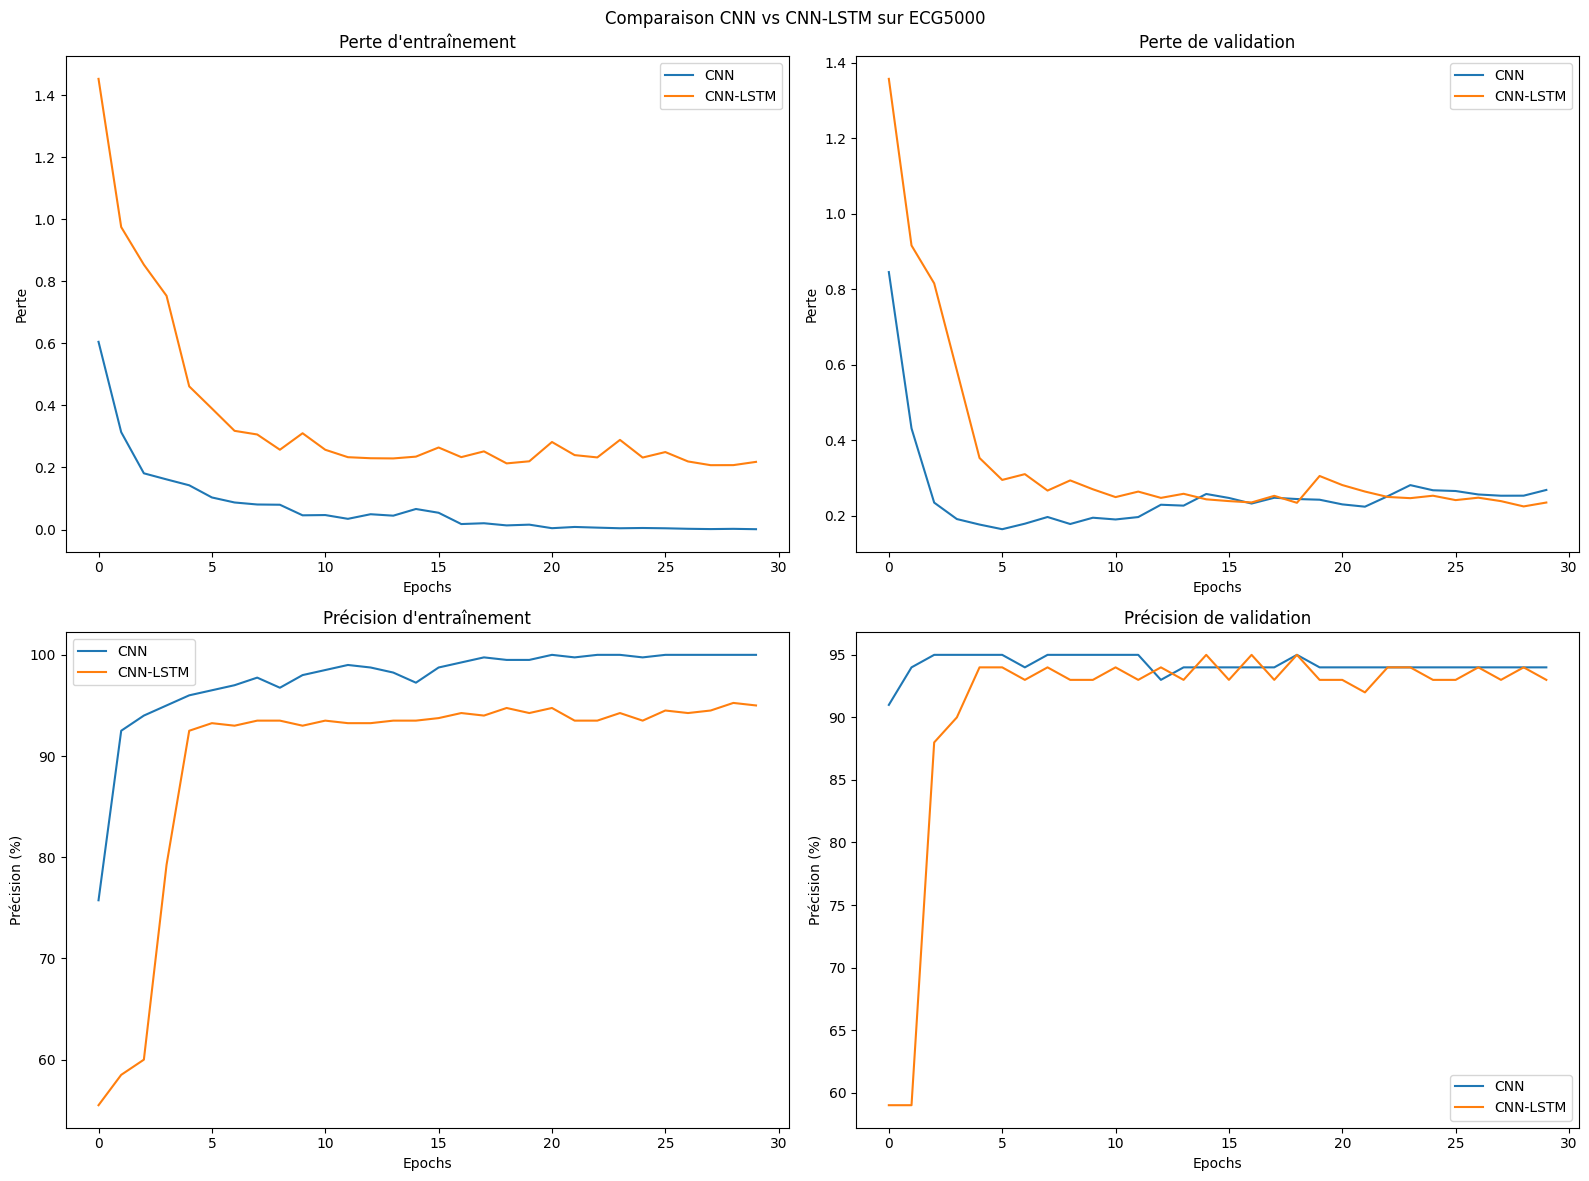


Résumé des performances sur l'ensemble de test:
CNN: Perte = 0.4260, Précision = 93.13%
CNN-LSTM: Perte = 0.3186, Précision = 92.64%

Test de l'impact des hyperparamètres...

Test avec LR=0.01, Batch Size=32
Epoch 1/5 | Train Loss: 4.5736 | Train Acc: 59.50% | Val Loss: 0.9706 | Val Acc: 89.00%
Meilleur modèle sauvegardé avec une précision de validation de 89.00%
Epoch 2/5 | Train Loss: 1.1019 | Train Acc: 90.75% | Val Loss: 0.3993 | Val Acc: 91.00%
Meilleur modèle sauvegardé avec une précision de validation de 91.00%
Epoch 3/5 | Train Loss: 0.6917 | Train Acc: 86.50% | Val Loss: 0.3057 | Val Acc: 92.00%
Meilleur modèle sauvegardé avec une précision de validation de 92.00%
Epoch 4/5 | Train Loss: 0.3139 | Train Acc: 92.00% | Val Loss: 0.3147 | Val Acc: 93.00%
Meilleur modèle sauvegardé avec une précision de validation de 93.00%
Epoch 5/5 | Train Loss: 0.2773 | Train Acc: 93.75% | Val Loss: 0.2313 | Val Acc: 96.00%
Meilleur modèle sauvegardé avec une précision de validation de 96.00%
T

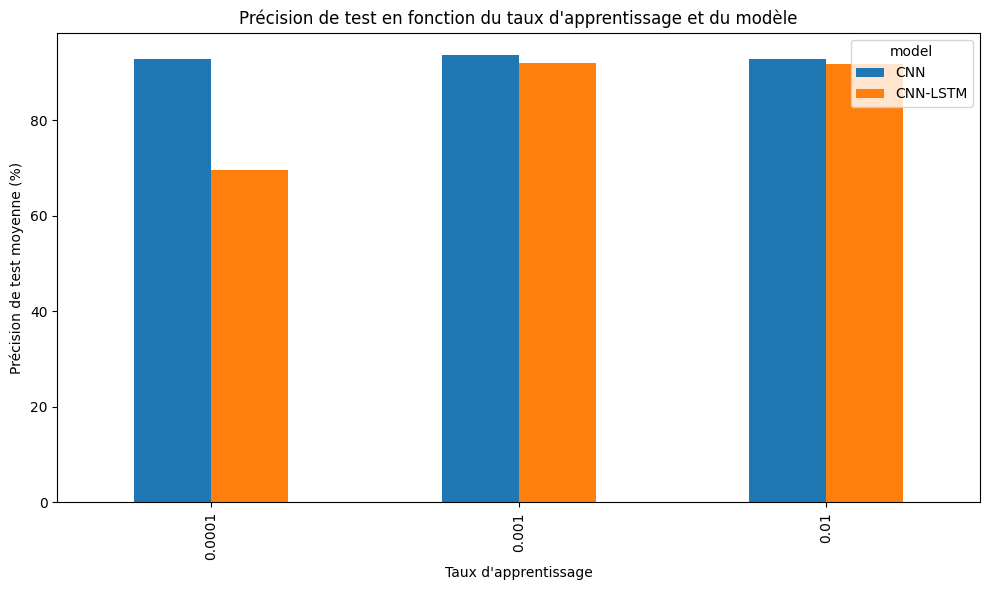

In [12]:
# Fonction principale
def main():
    # Chargement des données
    dataset_name = "ECG5000"  # Vous pouvez choisir un autre ensemble de données
    train_loader, val_loader, test_loader, seq_length, num_classes = load_ucr_dataset(dataset_name)
    
    print(f"\nEntraînement du modèle CNN pour les séries temporelles...")
    
    # Initialisation du modèle CNN, de la fonction de perte et de l'optimiseur
    cnn_model = TSCNN(seq_length, num_classes)
    
    # Afficher l'architecture du modèle CNN
    print("\n===== Architecture du modèle CNN =====")
    print(cnn_model)
    
    # Afficher les paramètres du modèle CNN
    print(f"\nNombre total de paramètres du modèle CNN: {sum(p.numel() for p in cnn_model.parameters())}")
    print(f"Nombre de paramètres entraînables: {sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)}")
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
    
    # Entraînement du modèle CNN
    cnn_history = train_model(
        cnn_model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        epochs=EPOCHS, 
        device=DEVICE
    )
    
    # Évaluation du modèle CNN
    print("\nÉvaluation du modèle CNN sur l'ensemble de test:")
    cnn_test_loss, cnn_test_acc = evaluate_model(cnn_model, test_loader, criterion, DEVICE)
    
    print(f"\nEntraînement du modèle hybride CNN-LSTM...")
    
    # Initialisation du modèle CNN-LSTM, de la fonction de perte et de l'optimiseur
    cnn_lstm_model = CNNLSTM(seq_length, num_classes)
    
    print("\n===== Architecture du modèle CNN LSTM =====")
    print(cnn_lstm_model)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=LEARNING_RATE)
    
    # Entraînement du modèle CNN-LSTM
    cnn_lstm_history = train_model(
        cnn_lstm_model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        epochs=EPOCHS, 
        device=DEVICE
    )
    
    # Évaluation du modèle CNN-LSTM
    print("\nÉvaluation du modèle CNN-LSTM sur l'ensemble de test:")
    cnn_lstm_test_loss, cnn_lstm_test_acc = evaluate_model(cnn_lstm_model, test_loader, criterion, DEVICE)
    
    # Comparer les performances
    plot_comparison(
        cnn_history, 
        cnn_lstm_history, 
        f"Comparaison CNN vs CNN-LSTM sur {dataset_name}"
    )
    
    print("\nRésumé des performances sur l'ensemble de test:")
    print(f"CNN: Perte = {cnn_test_loss:.4f}, Précision = {cnn_test_acc:.2f}%")
    print(f"CNN-LSTM: Perte = {cnn_lstm_test_loss:.4f}, Précision = {cnn_lstm_test_acc:.2f}%")
    
    # Test des hyperparamètres (décommenté pour exécuter)
    print("\nTest de l'impact des hyperparamètres...")
    hyperparameter_results = hyperparameter_test(
        train_loader, 
        val_loader, 
        test_loader, 
        seq_length, 
        num_classes, 
        DEVICE
    )

if __name__ == "__main__":
    main()